In [5]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.measure import find_contours

# Step 1: Load Images with resizing
def load_images(image_paths, target_size=None):
    images = []
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0
        if img is None:
            continue  # Skip if image couldn't be loaded
        if target_size is None:
            target_size = img.shape  # Set the first image size as target
        img_resized = cv2.resize(img, (target_size[1], target_size[0]))  # Resize to target size
        images.append(img_resized)
    return np.array(images)

# Step 2: Approximate Foreground (Object Intensity)
def approximate_foreground(images):
    return np.mean(images, axis=0)  # Average intensity across frames

# Step 3: Enhance Background
def enhance_background(background_image):
    return gaussian_filter(background_image, sigma=2)

# Step 4: Resize images to match reference
def resize_to_match(image, reference_image):
    return cv2.resize(image, (reference_image.shape[1], reference_image.shape[0]))

# Step 5: Compute Alpha Matte
def compute_alpha_matte(C, B, o):
    denominator = o - B
    denominator[denominator == 0] = np.finfo(float).eps  # Avoid division by zero
    alpha_matte = (C - B) / denominator
    return np.clip(alpha_matte, 0, 1)

# Step 6: Extract Contours
def extract_contours(alpha_matte, levels, min_length=100):
    contours = []
    for level in levels:
        contour_set = find_contours(alpha_matte, level)
        filtered_contours = [c for c in contour_set if len(c) > min_length]
        contours.append((level, filtered_contours))
    return contours

In [6]:

# Load images (motion-blurred frames)
image_files = sorted(glob.glob("imgs/img/*.jpg"))
images = load_images(image_files)

# Load and process background image
background_image_path = "imgs/background.jpg"
background_image = cv2.imread(background_image_path, cv2.IMREAD_GRAYSCALE) / 255.0
background_image = enhance_background(background_image)

# Estimate object intensity
object_intensity = approximate_foreground(images)

# Resize all images to match the blurred image
blurred_image = resize_to_match(images[-1], background_image)
background_image = resize_to_match(background_image, blurred_image)
object_intensity = resize_to_match(object_intensity, blurred_image)

# Compute alpha matte
alpha_matte = compute_alpha_matte(blurred_image, background_image, object_intensity)

# Extract contours from alpha matte
alpha_levels = [0.2, 0.5, 0.8]
min_contour_length = 100
contours = extract_contours(alpha_matte, alpha_levels, min_length=min_contour_length)

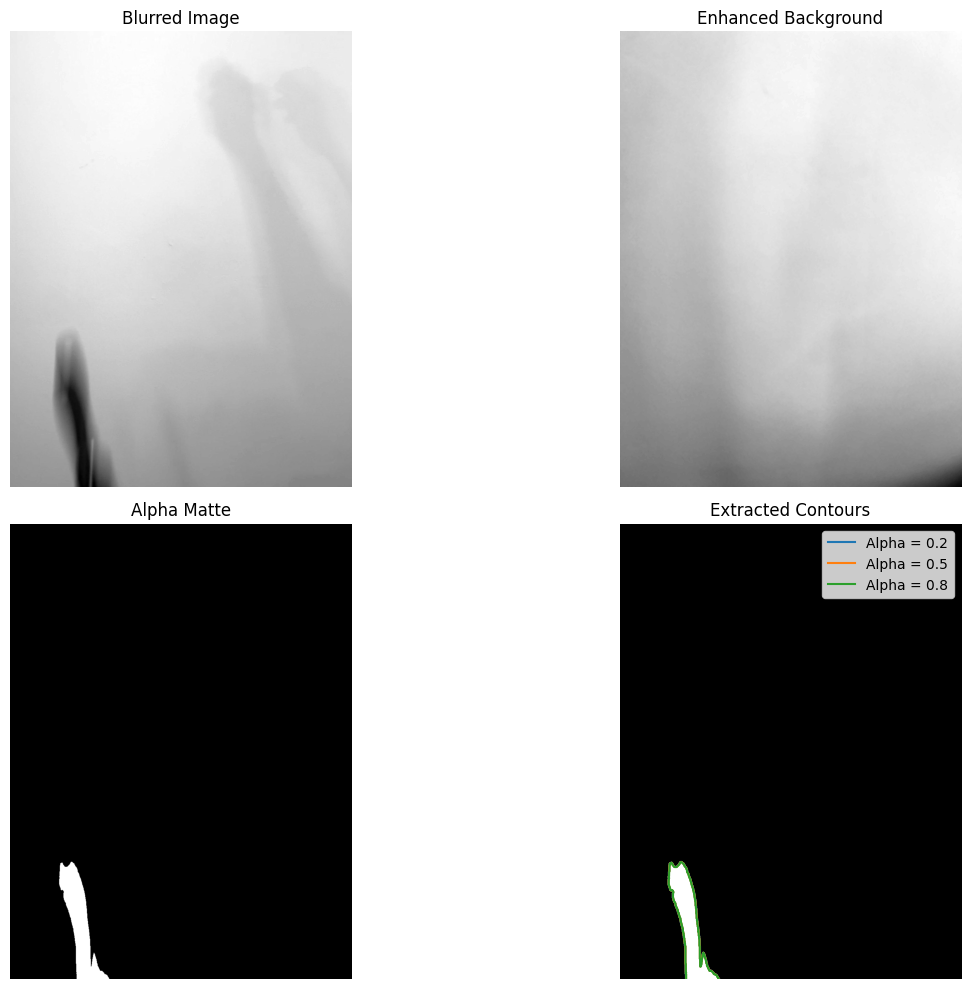

In [8]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.measure import find_contours

# Step 1: Load Images with resizing
def load_images(image_paths, target_size=None):
    images = []
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0
        if img is None:
            continue  # Skip if image couldn't be loaded
        if target_size is None:
            target_size = img.shape  # Set the first image size as target
        img_resized = cv2.resize(img, (target_size[1], target_size[0]))  # Resize to target size
        images.append(img_resized)
    return np.array(images)

# Step 2: Approximate Foreground (Object Intensity)
def determine_object_intensity(blurred_image):
    return np.min(blurred_image)  # Find the darkest pixels assuming object is dark

# Step 3: Enhance Background
def enhance_background(background_image):
    return cv2.medianBlur((background_image * 255).astype(np.uint8), 5) / 255.0

# Step 4: Resize images to match reference
def resize_to_match(image, reference_image):
    return cv2.resize(image, (reference_image.shape[1], reference_image.shape[0]))

# Step 5: Compute Alpha Matte
def compute_alpha_matte(C, B, o):
    denominator = o - B
    denominator[denominator == 0] = np.finfo(float).eps  # Avoid division by zero
    alpha_matte = (C - B) / denominator
    return np.clip(alpha_matte, 0, 1)

# Step 6: Post-process Alpha Matte
def refine_alpha_matte(alpha_matte):
    alpha_matte = cv2.normalize(alpha_matte, None, 0, 1, cv2.NORM_MINMAX)
    alpha_matte = cv2.GaussianBlur(alpha_matte, (5, 5), 0)
    _, alpha_matte_bin = cv2.threshold(alpha_matte, 0.5, 1, cv2.THRESH_BINARY)
    return alpha_matte_bin

# Step 7: Extract Contours
def extract_contours(alpha_matte, levels, min_length=100):
    contours = []
    for level in levels:
        contour_set = find_contours(alpha_matte, level)
        filtered_contours = [c for c in contour_set if len(c) > min_length]
        contours.append((level, filtered_contours))
    return contours

# Load images (motion-blurred frames)
image_files = sorted(glob.glob("imgs/img/*.jpg"))
images = load_images(image_files)

# Load and process background image
background_image_path = "imgs/background.jpg"
background_image = cv2.imread(background_image_path, cv2.IMREAD_GRAYSCALE) / 255.0
background_image = enhance_background(background_image)

# Estimate object intensity
blurred_image = resize_to_match(images[-1], background_image)
background_image = resize_to_match(background_image, blurred_image)
object_intensity = determine_object_intensity(blurred_image)

# Compute alpha matte
alpha_matte = compute_alpha_matte(blurred_image, background_image, object_intensity)
alpha_matte = refine_alpha_matte(alpha_matte)

# Extract contours from alpha matte
alpha_levels = [0.2, 0.5, 0.8]
min_contour_length = 100
contours = extract_contours(alpha_matte, alpha_levels, min_length=min_contour_length)

# Visualization
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(blurred_image, cmap="gray")
plt.title("Blurred Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(background_image, cmap="gray")
plt.title("Enhanced Background")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(alpha_matte, cmap="gray")
plt.title("Alpha Matte")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(alpha_matte, cmap="gray")
for level, contour_set in contours:
    for contour in contour_set:
        plt.plot(contour[:, 1], contour[:, 0], label=f"Alpha = {level}")
plt.legend(loc="upper right")
plt.title("Extracted Contours")
plt.axis("off")

plt.tight_layout()
plt.show()


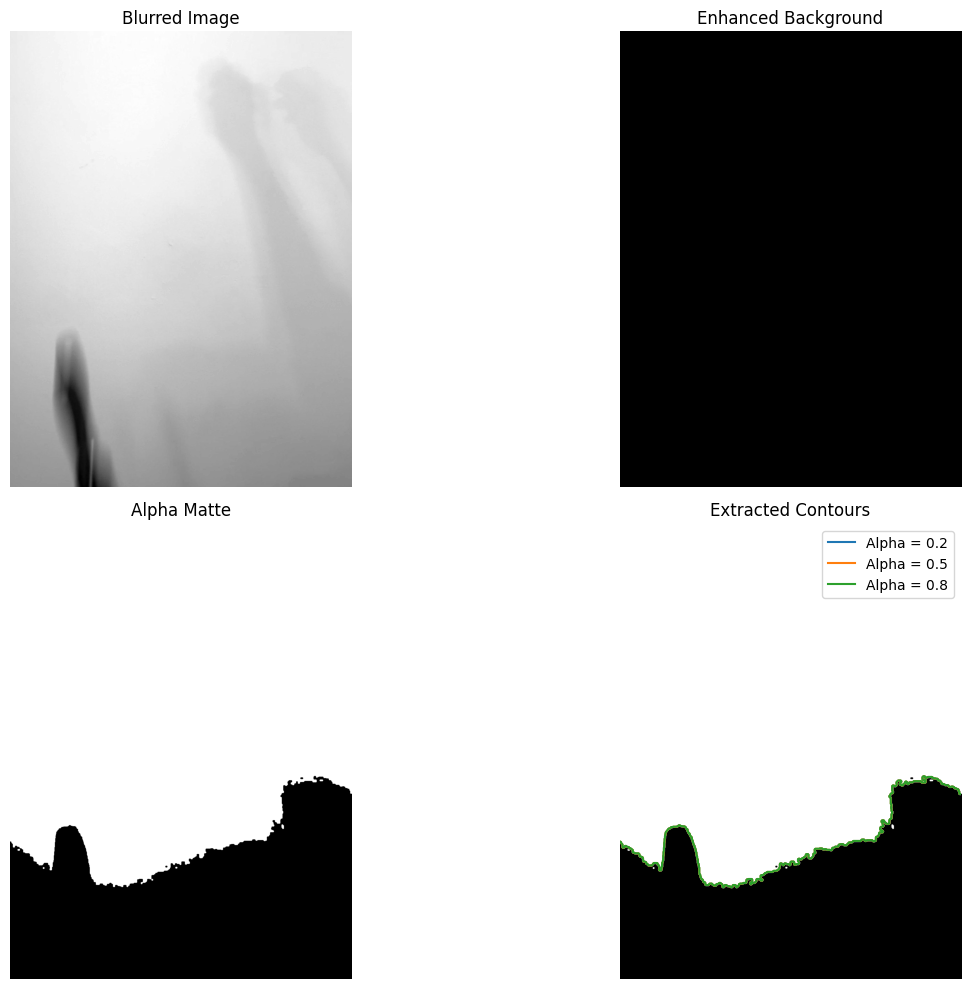

In [10]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.measure import find_contours

# Load Images with resizing
def load_images(image_paths, target_size=None):
    images = []
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0
        if img is None:
            continue  # Skip if image couldn't be loaded
        if target_size is None:
            target_size = img.shape  # Set the first image size as target
        img_resized = cv2.resize(img, (target_size[1], target_size[0]))  # Resize to target size
        images.append(img_resized)
    return np.array(images)

# Adaptive Background Correction
def adaptive_background_correction(background_image):
    background_blur = cv2.GaussianBlur((background_image * 255).astype(np.uint8), (15, 15), 0)
    background_corrected = cv2.adaptiveThreshold(background_blur, 255, 
                                                 cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                                 cv2.THRESH_BINARY, 21, 5)
    return background_corrected / 255.0

# Segment Foreground
def segment_foreground(image):
    image = cv2.equalizeHist((image * 255).astype(np.uint8)) / 255.0
    _, binary_image = cv2.threshold(image, 0.3, 1, cv2.THRESH_BINARY_INV)
    kernel = np.ones((5, 5), np.uint8)
    binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
    return binary_image

# Resize images to match reference
def resize_to_match(image, reference_image):
    return cv2.resize(image, (reference_image.shape[1], reference_image.shape[0]))

# Compute Alpha Matte
def compute_alpha_matte(C, B, o):
    denominator = o - B
    denominator[denominator == 0] = np.finfo(float).eps  # Avoid division by zero
    alpha_matte = (C - B) / denominator
    return np.clip(alpha_matte, 0, 1)

# Post-process Alpha Matte
def refine_alpha_matte(alpha_matte):
    alpha_matte = cv2.normalize(alpha_matte, None, 0, 1, cv2.NORM_MINMAX)
    alpha_matte = cv2.GaussianBlur(alpha_matte, (5, 5), 0)
    _, alpha_matte_bin = cv2.threshold(alpha_matte, 0.5, 1, cv2.THRESH_BINARY)
    return alpha_matte_bin

# Extract Contours
def extract_contours(alpha_matte, levels, min_length=100):
    contours = []
    for level in levels:
        contour_set = find_contours(alpha_matte, level)
        filtered_contours = [c for c in contour_set if len(c) > min_length]
        contours.append((level, filtered_contours))
    return contours

# Load images (motion-blurred frames)
image_files = sorted(glob.glob("imgs/img/*.jpg"))
images = load_images(image_files)

# Load and process background image
background_image_path = "imgs/background.jpg"
background_image = cv2.imread(background_image_path, cv2.IMREAD_GRAYSCALE) / 255.0
background_image = adaptive_background_correction(background_image)

# Estimate object intensity using foreground segmentation
blurred_image = resize_to_match(images[-1], background_image)
background_image = resize_to_match(background_image, blurred_image)
object_intensity = segment_foreground(blurred_image)

# Compute alpha matte
alpha_matte = compute_alpha_matte(blurred_image, background_image, object_intensity)
alpha_matte = refine_alpha_matte(alpha_matte)

# Extract contours from alpha matte
alpha_levels = [0.2, 0.5, 0.8]
min_contour_length = 100
contours = extract_contours(alpha_matte, alpha_levels, min_length=min_contour_length)

# Visualization
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(blurred_image, cmap="gray")
plt.title("Blurred Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(background_image, cmap="gray")
plt.title("Enhanced Background")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(alpha_matte, cmap="gray")
plt.title("Alpha Matte")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(alpha_matte, cmap="gray")
for level, contour_set in contours:
    for contour in contour_set:
        plt.plot(contour[:, 1], contour[:, 0], label=f"Alpha = {level}")
plt.legend(loc="upper right")
plt.title("Extracted Contours")
plt.axis("off")

plt.tight_layout()
plt.show()


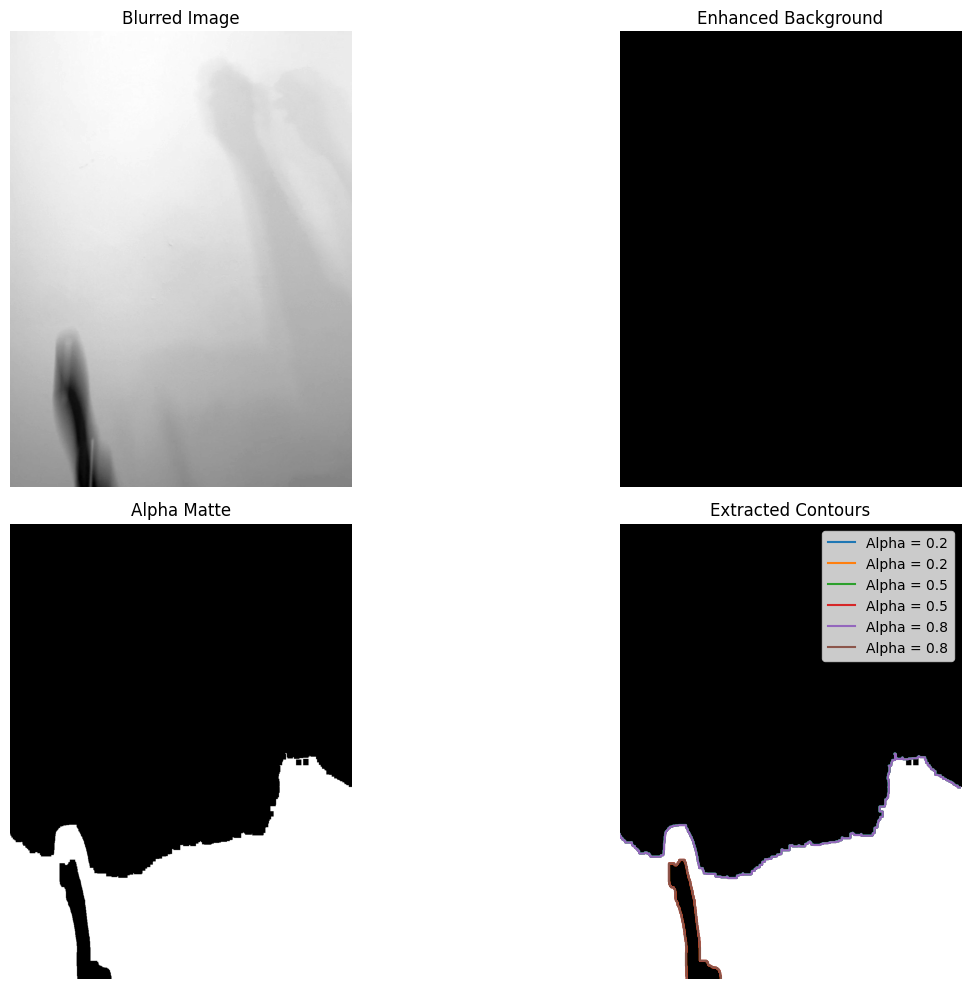

In [11]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.measure import find_contours

# Load Images with resizing
def load_images(image_paths, target_size=None):
    images = []
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0
        if img is None:
            continue  # Skip if image couldn't be loaded
        if target_size is None:
            target_size = img.shape  # Set the first image size as target
        img_resized = cv2.resize(img, (target_size[1], target_size[0]))  # Resize to target size
        images.append(img_resized)
    return np.array(images)

# Adaptive Background Correction
def adaptive_background_correction(background_image):
    background_blur = cv2.GaussianBlur((background_image * 255).astype(np.uint8), (15, 15), 0)
    background_corrected = cv2.adaptiveThreshold(background_blur, 255, 
                                                 cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                                 cv2.THRESH_BINARY, 21, 5)
    return background_corrected / 255.0

# Enhance contrast using CLAHE
def enhance_contrast(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply((image * 255).astype(np.uint8))
    return enhanced / 255.0

# Segment Foreground
def segment_foreground(image):
    image = enhance_contrast(image)
    _, binary_image = cv2.threshold(image, 0.3, 1, cv2.THRESH_BINARY_INV)
    kernel = np.ones((5, 5), np.uint8)
    binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
    return binary_image

# Remove shadows
def remove_shadows(alpha_matte):
    kernel = np.ones((15, 15), np.uint8)
    processed = cv2.morphologyEx(alpha_matte, cv2.MORPH_CLOSE, kernel)
    return processed

# Adaptive thresholding for alpha matte
def adaptive_thresholding(alpha_matte):
    mean_val = np.mean(alpha_matte)
    std_val = np.std(alpha_matte)
    threshold_val = mean_val + 0.5 * std_val
    _, binary_alpha = cv2.threshold(alpha_matte, threshold_val, 1, cv2.THRESH_BINARY)
    return binary_alpha

# Remove small objects
def remove_small_objects(alpha_matte, min_size=500):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats((alpha_matte * 255).astype(np.uint8), connectivity=8)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] < min_size:
            alpha_matte[labels == i] = 0
    return alpha_matte

# Resize images to match reference
def resize_to_match(image, reference_image):
    return cv2.resize(image, (reference_image.shape[1], reference_image.shape[0]))

# Compute Alpha Matte
def compute_alpha_matte(C, B, o):
    denominator = o - B
    denominator[denominator == 0] = np.finfo(float).eps  # Avoid division by zero
    alpha_matte = (C - B) / denominator
    return np.clip(alpha_matte, 0, 1)

# Extract Contours
def extract_contours(alpha_matte, levels, min_length=100):
    contours = []
    for level in levels:
        contour_set = find_contours(alpha_matte, level)
        filtered_contours = [c for c in contour_set if len(c) > min_length]
        contours.append((level, filtered_contours))
    return contours

# Load images (motion-blurred frames)
image_files = sorted(glob.glob("imgs/img/*.jpg"))
images = load_images(image_files)

# Load and process background image
background_image_path = "imgs/background.jpg"
background_image = cv2.imread(background_image_path, cv2.IMREAD_GRAYSCALE) / 255.0
background_image = adaptive_background_correction(background_image)

# Estimate object intensity using foreground segmentation
blurred_image = resize_to_match(images[-1], background_image)
background_image = resize_to_match(background_image, blurred_image)
object_intensity = segment_foreground(blurred_image)

# Compute alpha matte
alpha_matte = compute_alpha_matte(blurred_image, background_image, object_intensity)
alpha_matte = remove_shadows(alpha_matte)
alpha_matte = adaptive_thresholding(alpha_matte)
alpha_matte = remove_small_objects(alpha_matte)

# Extract contours from alpha matte
alpha_levels = [0.2, 0.5, 0.8]
min_contour_length = 100
contours = extract_contours(alpha_matte, alpha_levels, min_length=min_contour_length)

# Visualization
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(blurred_image, cmap="gray")
plt.title("Blurred Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(background_image, cmap="gray")
plt.title("Enhanced Background")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(alpha_matte, cmap="gray")
plt.title("Alpha Matte")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(alpha_matte, cmap="gray")
for level, contour_set in contours:
    for contour in contour_set:
        plt.plot(contour[:, 1], contour[:, 0], label=f"Alpha = {level}")
plt.legend(loc="upper right")
plt.title("Extracted Contours")
plt.axis("off")

plt.tight_layout()
plt.show()


Alpha Matte Range: Min=0.0, Max=0.7668591395968938


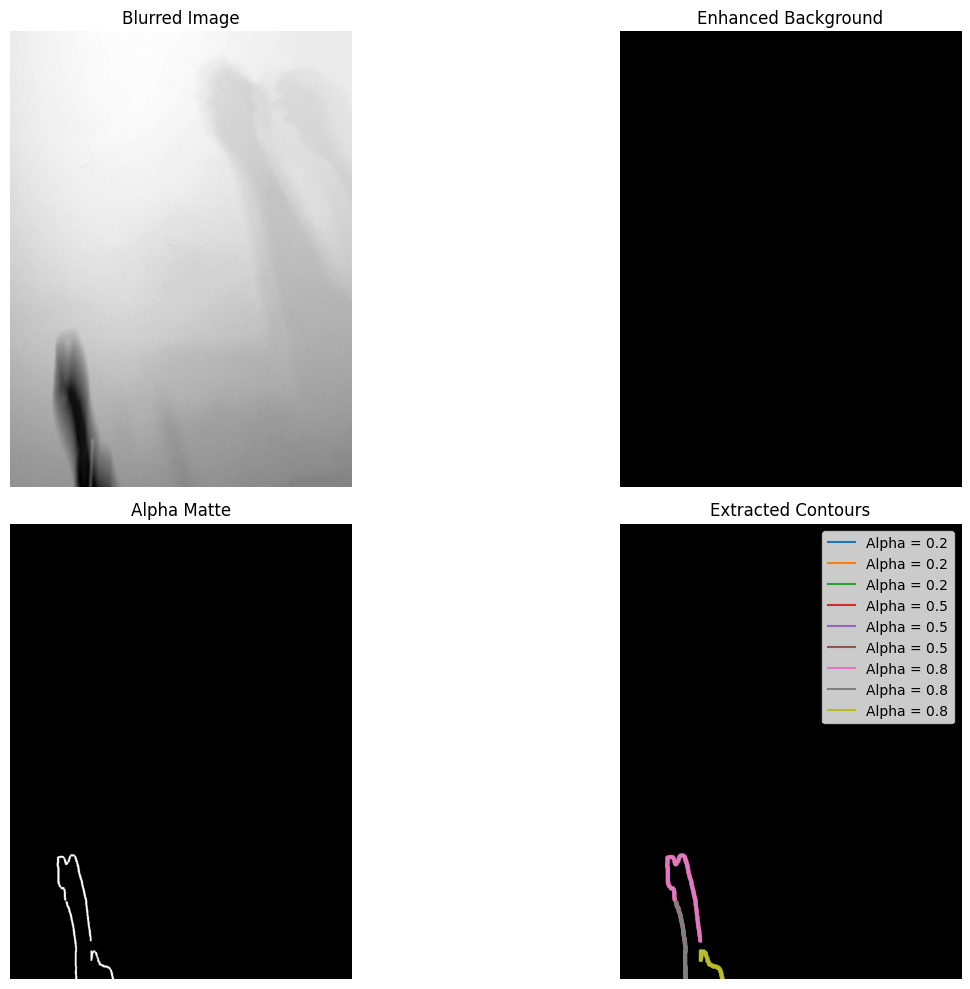

In [13]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.measure import find_contours

# Load Images with resizing
def load_images(image_paths, target_size=None):
    images = []
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0
        if img is None:
            continue  # Skip if image couldn't be loaded
        if target_size is None:
            target_size = img.shape  # Set the first image size as target
        img_resized = cv2.resize(img, (target_size[1], target_size[0]))  # Resize to target size
        images.append(img_resized)
    return np.array(images)

# Adaptive Background Correction
def adaptive_background_correction(background_image):
    background_blur = cv2.GaussianBlur((background_image * 255).astype(np.uint8), (15, 15), 0)
    background_corrected = cv2.adaptiveThreshold(background_blur, 255, 
                                                 cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                                 cv2.THRESH_BINARY, 21, 5)
    return background_corrected / 255.0

# Enhance contrast using CLAHE
def enhance_contrast(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply((image * 255).astype(np.uint8))
    return enhanced / 255.0

# Segment Foreground
def segment_foreground(image):
    image = enhance_contrast(image)
    _, binary_image = cv2.threshold(image, 0.3, 1, cv2.THRESH_BINARY_INV)
    kernel = np.ones((5, 5), np.uint8)
    binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
    return binary_image

# Remove shadows with refined morphology
def remove_shadows(alpha_matte):
    kernel = np.ones((5, 5), np.uint8)
    processed = cv2.morphologyEx(alpha_matte, cv2.MORPH_OPEN, kernel)
    return processed

# Local adaptive threshold for alpha matte
def local_adaptive_threshold(alpha_matte):
    blurred = cv2.GaussianBlur(alpha_matte, (15, 15), 0)
    alpha_matte = alpha_matte / (blurred + np.finfo(float).eps)
    alpha_matte = cv2.normalize(alpha_matte, None, 0, 1, cv2.NORM_MINMAX)
    mean_val = np.mean(alpha_matte)
    std_val = np.std(alpha_matte)
    threshold_val = mean_val + 0.2 * std_val  # Adjusted threshold
    _, binary_alpha = cv2.threshold(alpha_matte, threshold_val, 1, cv2.THRESH_BINARY)
    return binary_alpha

# Check alpha matte value range
def check_alpha_range(alpha_matte):
    min_val, max_val, _, _ = cv2.minMaxLoc(alpha_matte)
    print(f"Alpha Matte Range: Min={min_val}, Max={max_val}")
    return alpha_matte

# Remove small objects
def remove_small_objects(alpha_matte, min_size=500):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats((alpha_matte * 255).astype(np.uint8), connectivity=8)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] < min_size:
            alpha_matte[labels == i] = 0
    return alpha_matte

# Resize images to match reference
def resize_to_match(image, reference_image):
    return cv2.resize(image, (reference_image.shape[1], reference_image.shape[0]))

# Compute Alpha Matte
def compute_alpha_matte(C, B, o):
    denominator = o - B
    denominator[denominator == 0] = np.finfo(float).eps  # Avoid division by zero
    alpha_matte = (C - B) / denominator
    return np.clip(alpha_matte, 0, 1)

# Extract Contours
def extract_contours(alpha_matte, levels, min_length=100):
    contours = []
    for level in levels:
        contour_set = find_contours(alpha_matte, level)
        filtered_contours = [c for c in contour_set if len(c) > min_length]
        contours.append((level, filtered_contours))
    return contours

# Load images (motion-blurred frames)
image_files = sorted(glob.glob("imgs/img/*.jpg"))
images = load_images(image_files)

# Load and process background image
background_image_path = "imgs/background.jpg"
background_image = cv2.imread(background_image_path, cv2.IMREAD_GRAYSCALE) / 255.0
background_image = adaptive_background_correction(background_image)

# Estimate object intensity using foreground segmentation
blurred_image = resize_to_match(images[-1], background_image)
background_image = resize_to_match(background_image, blurred_image)
object_intensity = segment_foreground(blurred_image)

# Compute alpha matte
alpha_matte = compute_alpha_matte(blurred_image, background_image, object_intensity)
alpha_matte = check_alpha_range(alpha_matte)
alpha_matte = local_adaptive_threshold(alpha_matte)
alpha_matte = remove_shadows(alpha_matte)
alpha_matte = remove_small_objects(alpha_matte)

# Extract contours from alpha matte
alpha_levels = [0.2, 0.5, 0.8]
min_contour_length = 100
contours = extract_contours(alpha_matte, alpha_levels, min_length=min_contour_length)

# Visualization
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(blurred_image, cmap="gray")
plt.title("Blurred Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(background_image, cmap="gray")
plt.title("Enhanced Background")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(alpha_matte, cmap="gray")
plt.title("Alpha Matte")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(alpha_matte, cmap="gray")
for level, contour_set in contours:
    for contour in contour_set:
        plt.plot(contour[:, 1], contour[:, 0], label=f"Alpha = {level}")
plt.legend(loc="upper right")
plt.title("Extracted Contours")
plt.axis("off")

plt.tight_layout()
plt.show()
